## Imports

In [246]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [247]:
n_classes = 4

## Data Preprocessing

In [248]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_data = train_dataset.data
train_targets = train_dataset.targets
test_data = test_dataset.data
test_targets = test_dataset.targets

print("Number of original training examples:", len(train_data))
print("Number of original test examples:", len(test_data))

Number of original training examples: 60000
Number of original test examples: 10000


In [249]:
train_data = train_data.float()
test_data = test_data.float()

In [250]:
# Print the shapes of the data
print(f"train_data.shape = {train_data.shape}")
print(f"test_data.shape = {test_data.shape}")

train_data.shape = torch.Size([60000, 28, 28])
test_data.shape = torch.Size([10000, 28, 28])


In [251]:
def filter_n_classes(data, targets, n_classes):
    indices = torch.zeros(len(targets), dtype=torch.bool)
    for i in range(n_classes):
        indices |= (targets == i)
    data, targets = data[indices], targets[indices]
    return data, targets

train_data, train_targets = filter_n_classes(train_data, train_targets, n_classes)
test_data, test_targets = filter_n_classes(test_data, test_targets, n_classes)

print("Number of filtered training examples:", len(train_data))
print("Number of filtered test examples:", len(test_data))

Number of filtered training examples: 24000
Number of filtered test examples: 4000


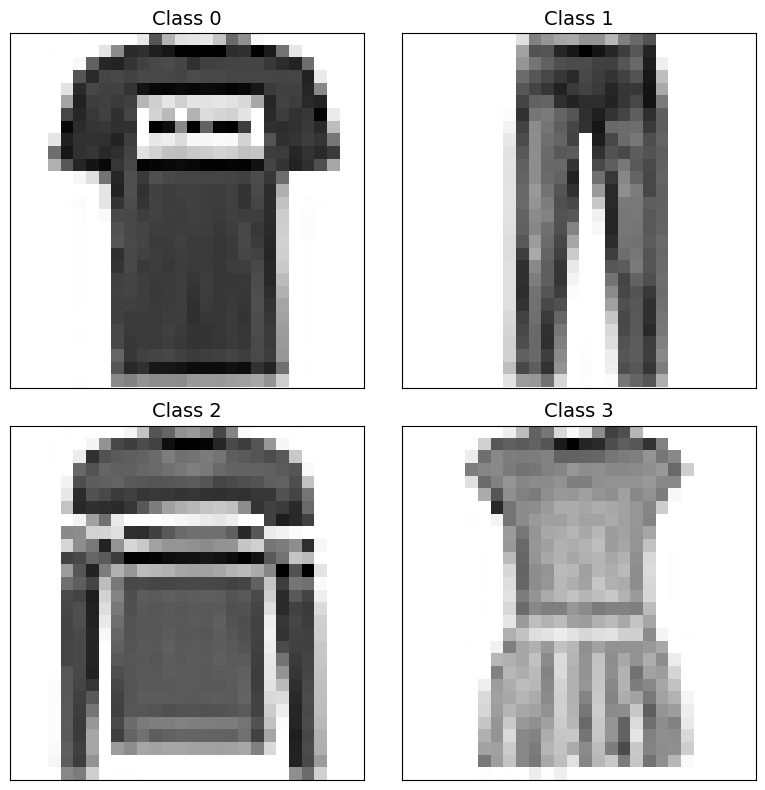

In [252]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
classes = list(range(n_classes))  # Classes 0, 1, 2, 3

# Loop over the classes
for i, cls in enumerate(classes):
    # Find the first index where the target equals the class
    indices = (train_targets == cls).nonzero(as_tuple=True)[0]
    if len(indices) > 0:
        idx = indices[0].item()  # Convert tensor index to integer
        img = train_data[idx].squeeze()  # Remove channel dimensions if present
        ax = axs[i // 2, i % 2]
        ax.imshow(img, cmap='Greys')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Class {cls}", fontsize=14)

plt.tight_layout()
plt.show()

In [253]:
# 1 Hot encoding the targets
def one_hot_encode(targets, num_classes):
    return torch.eye(num_classes)[targets]

train_targets = one_hot_encode(train_targets, n_classes)
test_targets = one_hot_encode(test_targets, n_classes)

In [254]:
# Add channel dimension
train_data = train_data.unsqueeze(1)
test_data = test_data.unsqueeze(1)

In [255]:
EPOCHS = 50
BATCH_SIZE = 32
NUM_EXAMPLES_TRAIN = 10000
NUM_EXAMPLES_TEST = 1000

In [256]:
# Take only the first 1000 examples for training and 250 for testing
train_data, train_targets = train_data[:NUM_EXAMPLES_TRAIN], train_targets[:NUM_EXAMPLES_TRAIN]
test_data, test_targets = test_data[:NUM_EXAMPLES_TEST], test_targets[:NUM_EXAMPLES_TEST]

print("Number of training examples:", len(train_data))
print("Number of test examples:", len(test_data))

Number of training examples: 10000
Number of test examples: 1000


In [257]:
train_loader = DataLoader(list(zip(train_data, train_targets)), batch_size=BATCH_SIZE, shuffle=True)

## Quantum Circuit

In [258]:
n_qubits = n_classes
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

In [259]:
@qml.qnode(dev, interface="torch")
def qnode_angle(inputs, weights):

    # Encoding (Angle/Basis Encoding)
    if len(inputs.shape) == 1:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[ii], wires=ii)
    else:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[:,ii], wires=ii)


    # Variational Layer
    for jj in range(n_layers):
        # Rotation Layer
        for ii in range(n_qubits):
            qml.U3(weights[jj,ii,0], weights[jj,ii,1], weights[jj,ii,2], wires=ii)

        # Entangling Layer
        for ii in range(n_qubits-1):
            qml.CNOT(wires=[ii, ii+1])
        qml.CNOT(wires=[n_qubits-1, 0])


    # Return a list of expectation values
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_layers, n_qubits, 3)}
print(weight_shapes)

{'weights': (3, 4, 3)}


(<Figure size 1900x500 with 1 Axes>, <Axes: >)

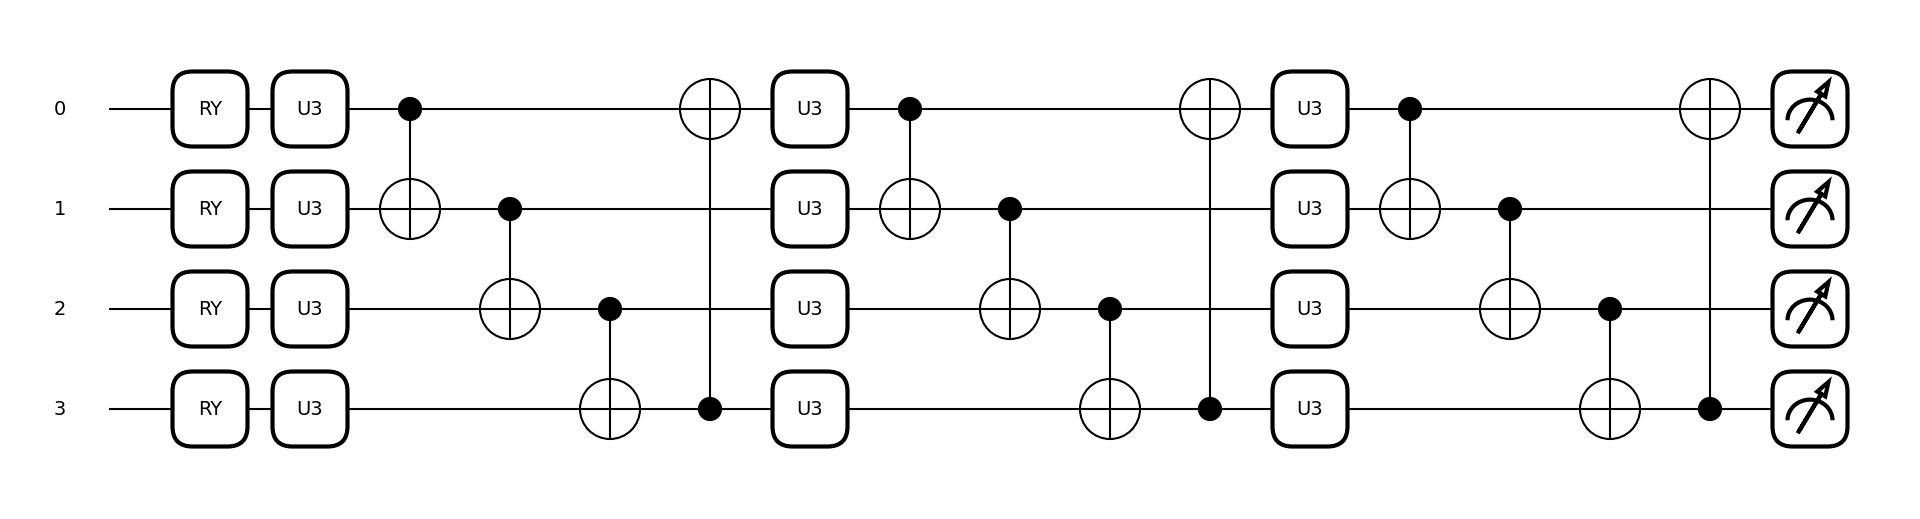

In [260]:
# Plot the circuit
qml.draw_mpl(qnode_angle, expansion_strategy="device")(torch.zeros(n_qubits), torch.zeros((n_layers, 2 * (n_qubits - 1) + 1, 3)))

## Neural Network

In [261]:
class QNN(nn.Module):
    def __init__(self, q_layer, q_weight_shapes, q_n_qubits):

        super(QNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.pre_blocks = nn.Sequential(
            nn.Linear(32 * 7 * 7, q_n_qubits),
            nn.Sigmoid()
        )

        self.quantum_layer = qml.qnn.TorchLayer(q_layer, q_weight_shapes)

        self.post_blocks = nn.Sequential(
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.pre_blocks(x)
        x = self.quantum_layer(x)
        x = self.post_blocks(x)
        return  x

In [262]:
model = QNN(qnode_angle, weight_shapes, n_qubits)

In [263]:
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

QNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pre_blocks): Sequential(
    (0): Linear(in_features=1568, out_features=4, bias=True)
    (1): Sigmoid()
  )
  (quantum_layer): <Quantum Torch Layer: func=qnode_angle>
  (post_blocks): Sequential(
    (0): Softmax(dim=1)
  )
)
Number of parameters: 11112


## Functions

In [264]:
def plot_quantum_layer_weights(q_layer_params, n_layers, n_qubits, min_val=None, max_val=None):
    """
    Plots the quantum layer weights.

    Parameters:
        q_layer_params (np.array): Array of weights with shape (n_layers, n_qubits, 3).
        n_layers (int): Number of layers.
        n_qubits (int): Number of qubits.
        min_val (float, optional): Minimum value for the color scale.
        max_val (float, optional): Maximum value for the color scale.
    """
    plt.figure(figsize=(20, 10))
    fig, axs = plt.subplots(1, n_layers, figsize=(7 * n_layers, 7))

    # Ensure axs is iterable for a single subplot
    if n_layers == 1:
        axs = [axs]

    param_names = ['theta', 'phi', 'delta']

    for layer in range(n_layers):
        # Transpose to have rows correspond to parameters and columns to qubits
        layer_params = q_layer_params[layer].T  # shape: (3, n_qubits)
        ax = axs[layer]
        im = ax.imshow(layer_params, cmap='viridis', vmin=min_val, vmax=max_val)

        # Annotate each cell with its value
        for i in range(layer_params.shape[0]):
            for j in range(layer_params.shape[1]):
                ax.text(j, i, f"{layer_params[i, j]:.2f}",
                        ha="center", va="center", color="white", fontsize=8)

        ax.set_title(f"Layer {layer}")
        ax.set_xticks(np.arange(n_qubits))
        ax.set_yticks(np.arange(3))
        ax.set_xticklabels(np.arange(n_qubits))
        ax.set_yticklabels(param_names)
        ax.set_xlabel("Qubit")
        ax.set_ylabel("Rotation Angle")
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

## Training

In [265]:
def accuracy(y_true, y_pred):
    # Convert one-hot encoded targets to class indices
    true_labels = torch.argmax(y_true, dim=1)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == true_labels).sum().item()
    return correct / len(true_labels)

In [266]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [267]:
acc_history = []
acc_test_history = []
loss_history = []
param_history = []

In [268]:
# Get initial loss and accuracy
model.eval()
with torch.no_grad():
    train_acc = accuracy(train_targets, model(train_data))
    test_acc = accuracy(test_targets, model(test_data))
print(f"Initial Train Accuracy: {train_acc}, Test Accuracy: {test_acc}")
acc_history.append(train_acc)
acc_test_history.append(test_acc)

# Get initial weights
param_history.append([p.detach().numpy().copy() for p in model.quantum_layer.parameters()][0])

Initial Train Accuracy: 0.1915, Test Accuracy: 0.191


In [269]:
for epoch in range(EPOCHS):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)

        loss = criterion(y_pred, y_batch)
        loss_history.append(loss.item())

        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        train_acc = accuracy(train_targets, model(train_data))
        test_acc = accuracy(test_targets, model(test_data))
        acc_history.append(train_acc)
        acc_test_history.append(test_acc)

        # Get weights
        param_history.append([p.detach().numpy().copy() for p in model.quantum_layer.parameters()][0])


    print(f"Epoch {epoch+1}/{EPOCHS}, Train Accuracy: {train_acc}, Test Accuracy: {test_acc}")

Epoch 1/50, Train Accuracy: 0.6213, Test Accuracy: 0.619
Epoch 2/50, Train Accuracy: 0.6883, Test Accuracy: 0.689
Epoch 3/50, Train Accuracy: 0.7134, Test Accuracy: 0.71
Epoch 4/50, Train Accuracy: 0.7226, Test Accuracy: 0.718
Epoch 5/50, Train Accuracy: 0.7349, Test Accuracy: 0.732
Epoch 6/50, Train Accuracy: 0.7338, Test Accuracy: 0.73
Epoch 7/50, Train Accuracy: 0.7312, Test Accuracy: 0.728
Epoch 8/50, Train Accuracy: 0.7397, Test Accuracy: 0.742
Epoch 9/50, Train Accuracy: 0.7403, Test Accuracy: 0.739
Epoch 10/50, Train Accuracy: 0.7482, Test Accuracy: 0.745
Epoch 11/50, Train Accuracy: 0.7663, Test Accuracy: 0.759
Epoch 12/50, Train Accuracy: 0.7552, Test Accuracy: 0.753
Epoch 13/50, Train Accuracy: 0.7969, Test Accuracy: 0.785
Epoch 14/50, Train Accuracy: 0.7336, Test Accuracy: 0.728
Epoch 15/50, Train Accuracy: 0.8384, Test Accuracy: 0.819
Epoch 16/50, Train Accuracy: 0.8738, Test Accuracy: 0.86
Epoch 17/50, Train Accuracy: 0.8988, Test Accuracy: 0.871
Epoch 18/50, Train Accurac

KeyboardInterrupt: 

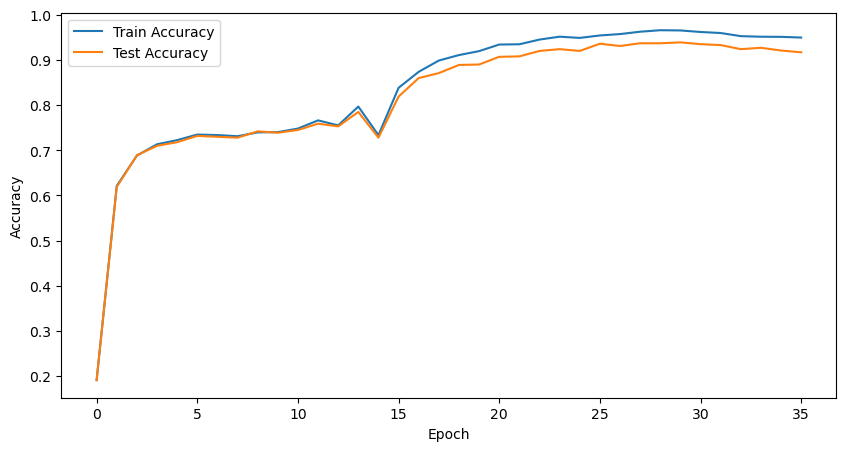

In [270]:
# Plot accuracy over time
plt.figure(figsize=(10, 5))
plt.plot(acc_history, label='Train Accuracy')
plt.plot(acc_test_history, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

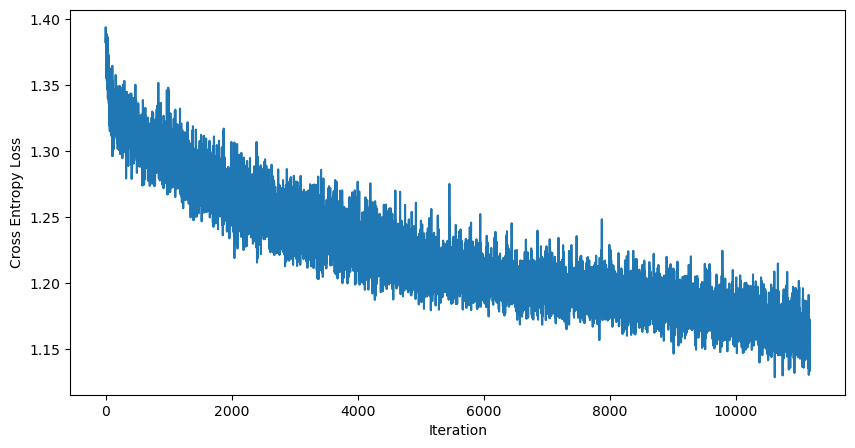

In [271]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Cross Entropy Loss")
plt.show()

## Animation

In [272]:
def animate_quantum_layer_weights(history_q_layer_params, n_layers, n_qubits, interval=200):
    n_steps = history_q_layer_params.shape[0]

    param_names = ['theta', 'phi', 'delta']
    fig, axs = plt.subplots(1, n_layers, figsize=(7 * n_layers, 7))

    # Ensure axs is iterable for a single subplot
    if n_layers == 1:
        axs = [axs]

    # Determine global vmin and vmax for color scale
    all_param_values = history_q_layer_params.flatten()
    global_vmin = np.min(all_param_values)
    global_vmax = np.max(all_param_values)

    ims = []
    texts = []

    # Initial data (first frame)
    first_frame_params = history_q_layer_params[0]

    for layer in range(n_layers):
        ax = axs[layer]

        layer_params = first_frame_params[layer].T  # shape: (3, n_qubits)

        im = ax.imshow(layer_params, cmap='viridis', vmin=global_vmin, vmax=global_vmax)
        ims.append(im)

        layer_texts = []
        for i in range(layer_params.shape[0]):
            row_texts = []
            for j in range(layer_params.shape[1]):
                txt = ax.text(j, i, f"{layer_params[i, j]:.2f}",
                                ha="center", va="center", color="white", fontsize=8)
                row_texts.append(txt)
            layer_texts.append(row_texts)
        texts.append(layer_texts)

        # Set static plot properties
        ax.set_title(f"Layer {layer}")
        ax.set_xticks(np.arange(n_qubits))
        ax.set_yticks(np.arange(3))
        ax.set_xticklabels(np.arange(n_qubits))
        ax.set_yticklabels(param_names)
        ax.set_xlabel("Qubit")
        ax.set_ylabel("Rotation Angle")

        # Add color bar for each subplot, based on the initial imshow
        cb = fig.colorbar(im, ax=ax)

    plt.tight_layout()


    def update(frame):
        current_params = history_q_layer_params[frame]
        updated_artists = [] # List to return artists that were modified

        for layer in range(n_layers):
            layer_params = current_params[layer].T # shape: (3, n_qubits)

            # Update the imshow data
            ims[layer].set_data(layer_params)
            updated_artists.append(ims[layer]) # Add the imshow object

            # Update the text annotations
            for i in range(3): # Loop through parameter indices (theta, phi, delta)
                for j in range(n_qubits): # Loop through qubits
                    # Make sure text color is visible - check against mean of vmin/vmax or specific threshold
                    # For simplicity, keeping fixed white color as in original
                    texts[layer][i][j].set_text(f"{layer_params[i, j]:.2f}")
                    updated_artists.append(texts[layer][i][j]) # Add the text object

        # Return the list of artists that were modified
        return updated_artists

    def init():
        initial_artists = []
        for im in ims:
            initial_artists.append(im)
        for layer_texts in texts:
            for row_texts in layer_texts:
                initial_artists.extend(row_texts) # Flatten the list of text objects

        return initial_artists


    # Create the animation
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=n_steps,
        init_func=init,     # Call init before the first frame
        blit=True,          # Use blitting for performance
        interval=interval,  # Delay between frames in ms
        repeat=False        # Don't repeat the animation by default
    )

    return ani

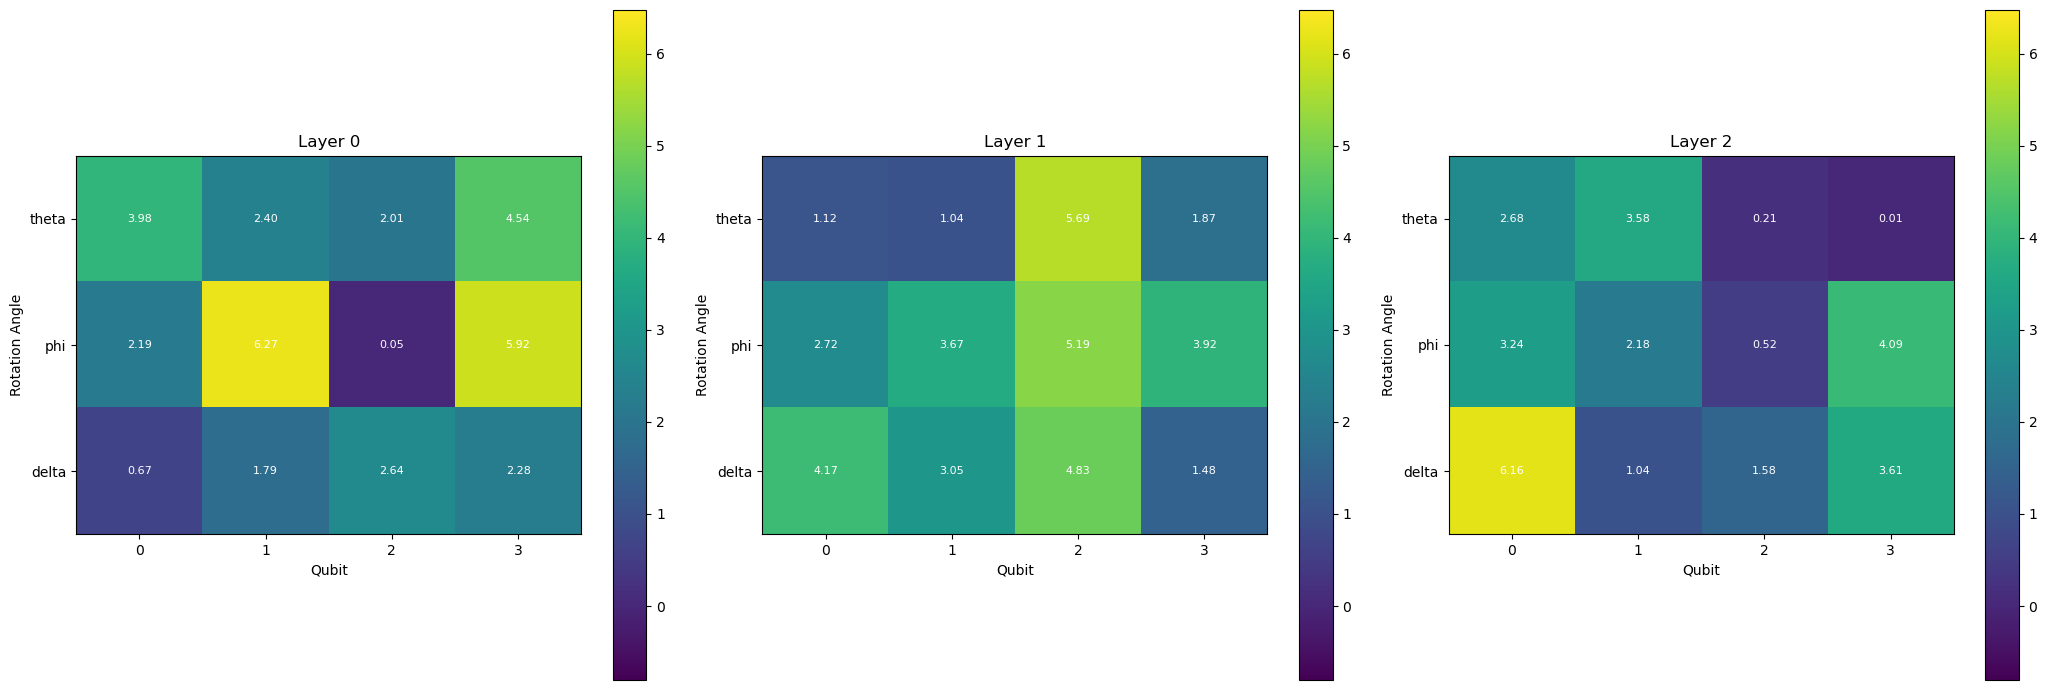

In [273]:
animation = animate_quantum_layer_weights(
    np.array(param_history),
    n_layers,
    n_qubits,
    interval=200
)

In [274]:
# Save as mp4
animation.save('quantum_layer_weights_animation.mp4', writer='ffmpeg', fps=5)